In [12]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [ ]:
data_dir = 'data'

In [5]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, 0))

In [6]:
data_network

,row,col
0,1,5
1,1,17
2,2,3
3,2,9
4,3,2
...,...,...
3621,999,837
3622,999,930
3623,999,989
3624,999,993


In [7]:
n_node = len(data_latent); n_node

1000

In [16]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
), shape=(n_node,n_node)).toarray()

In [17]:
G = KECENI.Graph(Adj)

In [18]:
Ys = data_feature.iloc[:,6].values
Ts = data_feature.iloc[:,4].values
Xs = data_feature.iloc[:,0:3].values

# counterfactual of interest

In [19]:
i0 = 0

In [20]:
T0s_0 = Ts.copy(); T0s_0[:] = 0
T0s_1 = Ts.copy(); T0s_1[:] = 1

In [21]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0, 0, 0]), array([1, 1, 1]))

# groundtruth

In [22]:
YTR_0, YTR_1 = (-2, 2)
YTR_d = YTR_1 - YTR_0

In [23]:
YTR_0, YTR_1, YTR_d

(-2, 2, 4)

# estimation

In [33]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [34]:
n_sim = 80

In [35]:
YDRs_0 = np.zeros(n_sim); YDRs_1 = np.zeros(n_sim); YDRs_d = np.zeros(n_sim)

In [36]:
# change the following cell in to for loop with tqdm
for i_sim in tqdm(range(n_sim), total=n_sim, desc='SIM', position=0, leave=True):
    data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir,i_sim))
        
    Ys = data_feature.iloc[:,6].values
    Ts = data_feature.iloc[:,4].values
    Xs = data_feature.iloc[:,0:3].values
    
    n_node = Ys.shape[0]

    pi_fit = LogisticRegression(penalty=None).fit(Xs, Ts)
    pi_hat = pi_fit.predict_proba(Xs)[np.arange(n_node), Ts]
    
    mu_fit = LinearRegression().fit(np.concatenate([Xs, Ts[:,None]], -1), Ys)
    mu_hat = mu_fit.predict(np.concatenate([Xs, Ts[:,None]], -1))
    mu0_hat = mu_fit.predict(np.concatenate([Xs, np.full((n_node, 1), 0)], -1))
    mu1_hat = mu_fit.predict(np.concatenate([Xs, np.full((n_node, 1), 1)], -1))

    YDRs_0[i_sim] = np.mean(mu0_hat + (Ts == 0) * (Ys - mu_hat) / pi_hat)
    YDRs_1[i_sim] = np.mean(mu1_hat + (Ts == 1) * (Ys - mu_hat) / pi_hat)
    YDRs_d[i_sim] = YDRs_1[i_sim] - YDRs_0[i_sim]

SIM: 100%|██████████| 80/80 [00:00<00:00, 269.32it/s]


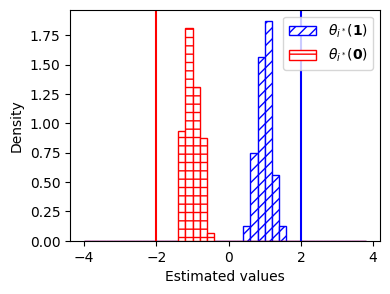

In [45]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_1, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='blue', hatch="///", 
         label=r'$\theta_{i^*}(\mathbf{1})$')
plt.axvline(YTR_1, color='blue')
plt.hist(YDRs_0, density=True, bins=np.arange(-4,4,0.2), 
         facecolor='white', edgecolor='red', hatch="--",
         label=r'$\theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_0, color='red')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

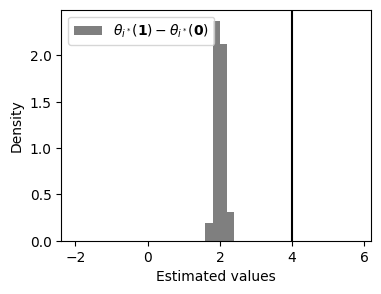

In [39]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d, color='black', alpha=0.5, density=True, bins=np.arange(-2,6,0.2),
         label=r'$\theta_{i^*}(\mathbf{1}) - \theta_{i^*}(\mathbf{0})$')
plt.axvline(YTR_d, color='black')
plt.xlabel('Estimated values'); plt.ylabel('Density'); plt.legend()

In [31]:
np.std(YDR1s), np.std(YDR2s), np.std(YDRds)

(0.197766956510276, 0.1983389167232598, 0.1277080245647294)